## A linear model of the Rossiter-McLaughlin Effect
Here we are Taylor-expanding the Doppler-shifted spectrum so we can self-consistently model the RM effect, without assuming it's a radial velocity shift! This was originally suggested by Hogg as a way to "punk" the RM effect with `starry`.

In [1]:
import starry
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

This is the value of $\beta$ we'll use in this notebook. It's unrealistically large, but useful for inspecting the line shifts by eye:

In [2]:
c = 3.00e8
veq = 300 * 1e3
beta = veq / c

And here are the occultor parameters; the size of the planet is also exaggerated:

In [3]:
xo = np.linspace(-1.5, 1.5, 1000)
yo = -0.4
ro = 0.25

## The idea

The idea is to Taylor expand the *spectral* specific intensity as follows:

$
I_\lambda(x, y) \approx I_\lambda^0 + \frac{\partial{I_\lambda^0}}{\partial{\beta}} \ \Delta \beta(x, y) + \frac{1}{2}\frac{\partial^2{I_\lambda^0}}{\partial{\beta^2}} \ \Delta \beta^2(x, y) \, + \, ...
$

The spectral specific intensity is therefore the sum of a spatially constant (spectral) term and terms proportional to powers of the radial velocity profile across the star, which we model in terms of spherical harmonics. The constants of proportionality are the derivatives of the spectrum with respect to the velocity; i.e., the terms that capture the effect of the Doppler shift at each wavelength.

## Let's create a fake model spectrum

We model spectral lines as simple Gaussians. We also compute the first few derivatives of the spectrum with respect to wavelength, which are analytic in this simple case.

In [4]:
np.random.seed(8)
nwav = 3000
wav = np.linspace(450, 600, nwav)
I = np.ones(nwav)
dIdl = np.zeros((2, nwav))
for i in range(12):
    mu = np.random.uniform(450, 600)
    sig = 1.0
    amp = np.random.uniform(0.01, 0.3)
    line = amp * np.exp(-(wav - mu) ** 2 / sig ** 2)
    I -= line
    dIdl[0] += 2 / sig ** 2 * line * (wav - mu)
    dIdl[1] += 2 / sig ** 2 * (line - (2 / sig ** 2 * line * (wav - mu)) * (wav - mu))

## Now let's compute its first two derivatives with respect to $\beta$

These are analytic! See `LinearizedDoppler.ipynb` for a derivation.

In [5]:
dIdb = np.zeros((2, nwav))
dIdb[0] = -wav * dIdl[0]
dIdb[1] = wav * dIdl[0] + wav ** 2 * dIdl[1]

## Plot the spectrum
This is the rest frame (spectral) specific intensity at a point on the surface of the star and its velocity derivatives.

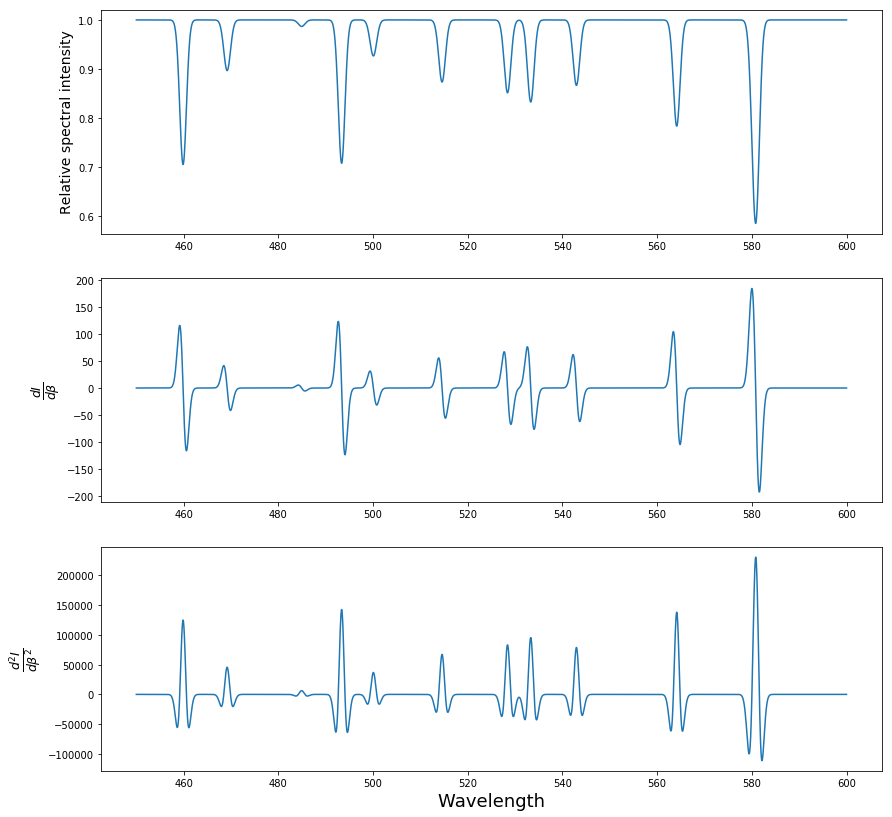

In [6]:
fig, ax = plt.subplots(3, figsize=(14, 14))
ax[0].plot(wav, I);
ax[1].plot(wav, dIdb[0]);
ax[2].plot(wav, dIdb[1]);
ax[0].set_ylabel("Relative spectral intensity", fontsize=14)
ax[1].set_ylabel(r"$\frac{dI}{d\beta}$", fontsize=18);
ax[2].set_ylabel(r"$\frac{d^2I}{d\beta^2}$", fontsize=18);
ax[2].set_xlabel("Wavelength", fontsize=18);

## Let's model this with `starry`: Linear term only

We're assigning this base spectrum to the `Y_{0,0}` coefficient (the constant term in our Taylor expansion) and the derivative to the `Y_{1,1}` coefficient (this is the radial velocity field of an axis-aligned, rigidly-rotating star).

In [7]:
map_lin = starry.Map(3, nwav=nwav)
map_lin[0, 0] = np.pi * I
map_lin[1, 1] = (np.pi / np.sqrt(3)) * beta * dIdb[0]

### Let's plot the spectrum at two points on the surface

It's clear that we've modeled something like a Doppler shift! (But note the "shoulders" next to each line; these are artifacts of the linearization, which we take care of below).

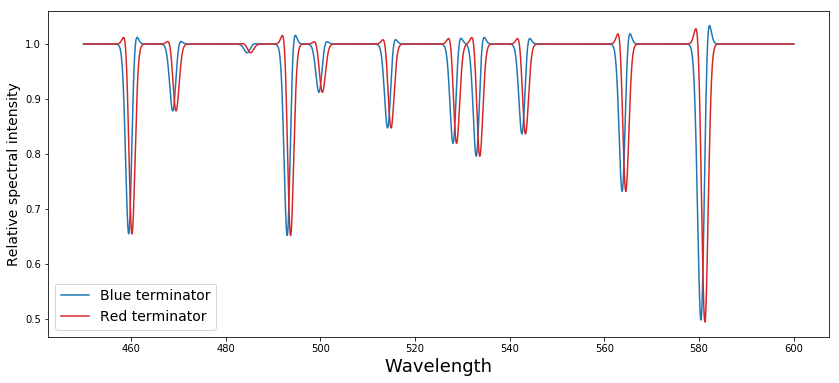

In [8]:
fig, ax = plt.subplots(1, figsize=(14, 6))
ax.plot(wav, map_lin(x=-1).T, label="Blue terminator", color="C0");
ax.plot(wav, map_lin(x=1).T, label="Red terminator", color="C3");
ax.set_ylabel("Relative spectral intensity", fontsize=14)
ax.set_xlabel("Wavelength", fontsize=18);
ax.legend(fontsize=14);

### Let's transit a large planet across this star
Let's plot an image of the star for reference

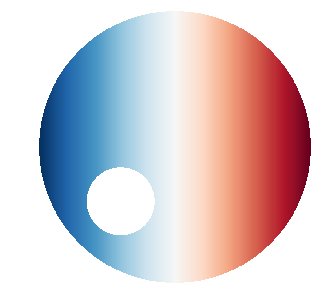

In [9]:
res = 1000
v = np.zeros((res, res)) * np.nan
for j, x in enumerate(np.linspace(-1, 1, res)):
    for i, y in enumerate(np.linspace(-1, 1, res)):
        r2 = x ** 2 + y ** 2
        if r2 <= 1:
            if ((x - (-0.4)) ** 2 + (y - yo) ** 2 > ro ** 2):
                z = np.sqrt(1 - r2)
                v[i, j] = x
fig = plt.figure(figsize=(5, 5))
plt.imshow(v, origin="lower", cmap="RdBu_r")
plt.gca().axis('off');

### Let's compute the `starry` model for the spectrum as a function of time

In [10]:
flux_lin = map_lin.flux(xo=xo, yo=yo, ro=ro)

Plot the intensity as a function of wavelength (horizontal axis) and time (vertical axis):

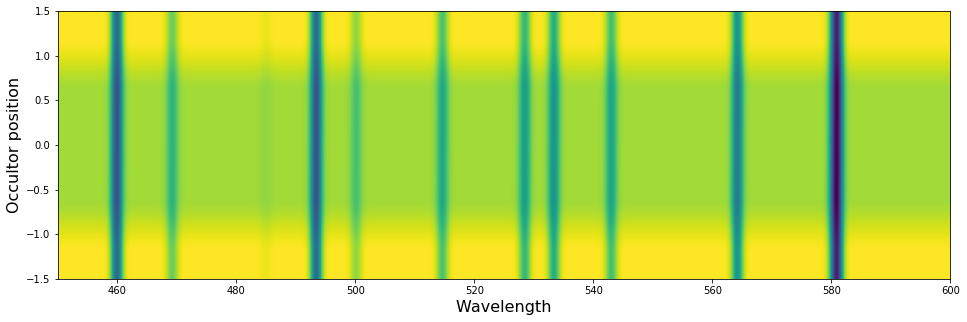

In [11]:
fig = plt.figure(figsize=(16,12))
plt.imshow(flux_lin, extent=(wav[0], wav[-1], xo[0], xo[-1]))
plt.gca().set_aspect(15)
plt.ylabel("Occultor position", fontsize=16)
plt.xlabel("Wavelength", fontsize=16);

Plot the spectrum minus the mean spectrum:

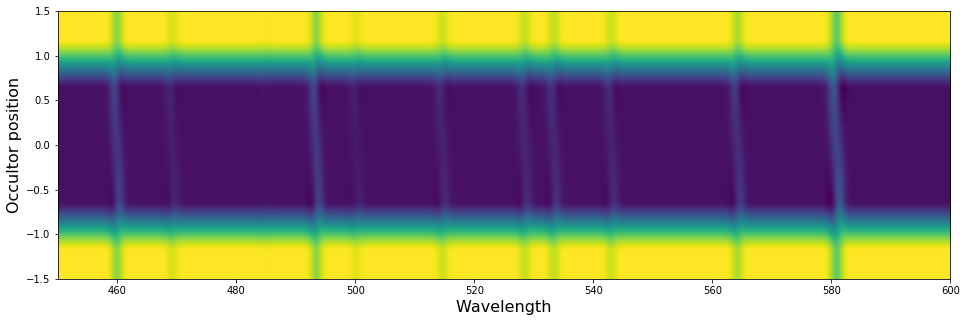

In [12]:
fig = plt.figure(figsize=(16,12))
fmean_lin = np.mean(flux_lin, axis=0).reshape(1, -1)
plt.imshow(flux_lin - fmean_lin, extent=(wav[0], wav[-1], xo[0], xo[-1]))
plt.gca().set_aspect(15)
plt.ylabel("Occultor position", fontsize=16)
plt.xlabel("Wavelength", fontsize=16);

And here's the base spectrum and the *difference* between the base spectrum when the planet is on the blue hemisphere and when it is on the red hemisphere:

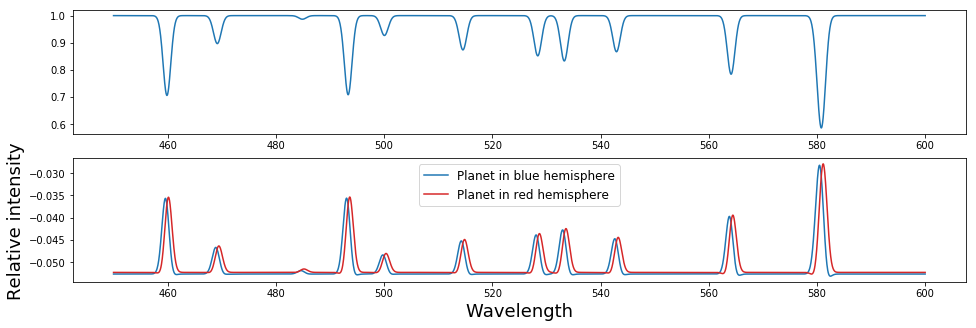

In [13]:
fig, ax = plt.subplots(2, figsize=(16, 5))
ax[0].plot(wav, I)
ax[1].plot(wav, flux_lin[250, :] / np.pi - I, label="Planet in blue hemisphere", color="C0")
ax[1].plot(wav, flux_lin[750, :] / np.pi - I, label="Planet in red hemisphere", color="C3");
plt.xlabel("Wavelength", fontsize=18)
plt.ylabel("Relative intensity", fontsize=18);
plt.legend(fontsize=12);

### Problem: the disk-integrated spectrum is just the mean spectrum
Meaning there is no line broadening! That's because the linear term integrates to zero (it's an odd function!)

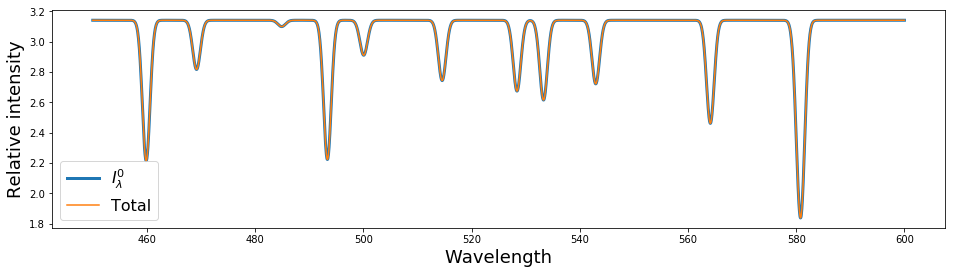

In [14]:
plt.figure(figsize=(16, 4))
plt.plot(wav, np.pi * I, label=r"$I_\lambda^0$", lw=3)
plt.plot(wav, map_lin.flux().reshape(-1, 1), label="Total")
plt.xlabel("Wavelength", fontsize=18)
plt.ylabel("Relative intensity", fontsize=18);
plt.legend(fontsize=16);

## Let's model this with `starry`: Quadratic correction

Let's add the quadratic term to see if it corrects for the broadening.

In [15]:
map_quad = starry.Map(3, nwav=nwav)
map_quad[0, 0] = np.pi * I
map_quad[1, 1] = (np.pi / np.sqrt(3)) * beta * dIdb[0]
map_quad[0, 0] += (np.pi / 3) * beta ** 2 * dIdb[1]
map_quad[2, 0] -= (np.sqrt(5) * np.pi / 15) * beta ** 2 * dIdb[1]
map_quad[2, 2] += (np.sqrt(5) * np.pi / 15) * beta ** 2 * dIdb[1]

### Let's plot the spectrum at two points on the surface

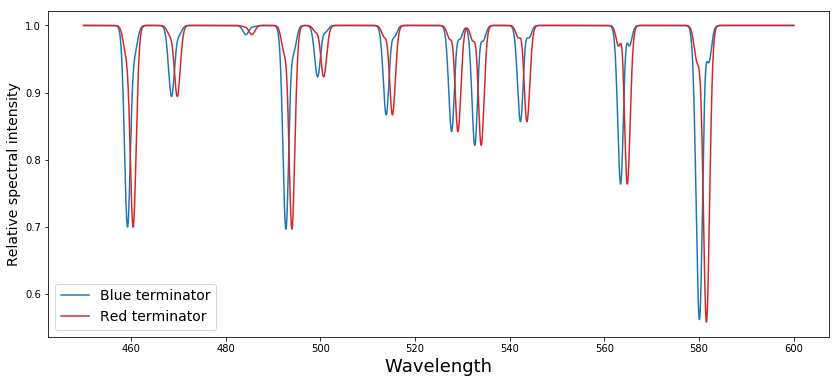

In [16]:
fig, ax = plt.subplots(1, figsize=(14, 6))
ax.plot(wav, map_quad(x=-1).T, label="Blue terminator", color="C0");
ax.plot(wav, map_quad(x=1).T, label="Red terminator", color="C3");
ax.set_ylabel("Relative spectral intensity", fontsize=14)
ax.set_xlabel("Wavelength", fontsize=18);
ax.legend(fontsize=14);

The shoulders are gone! There are still some artifacts, though. These will go away if we go to higher order or if we use more realistic (i.e., less relativistic) system parameters.

### Let's compute the `starry` model for the spectrum as a function of time

In [17]:
flux_quad = map_quad.flux(xo=xo, yo=yo, ro=ro)

Plot the intensity as a function of wavelength (horizontal axis) and time (vertical axis):

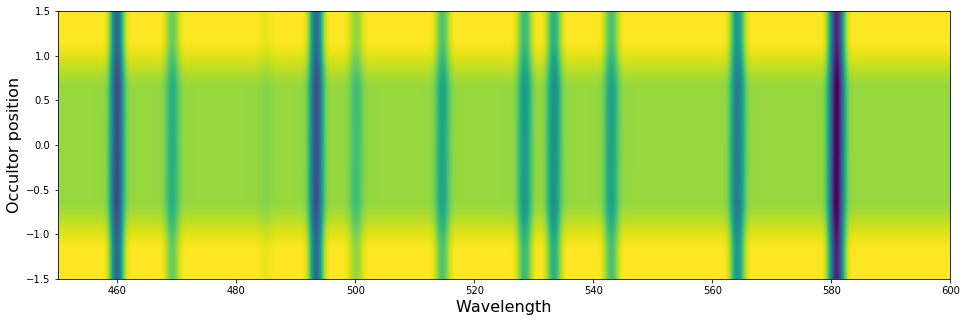

In [18]:
fig = plt.figure(figsize=(16,12))
plt.imshow(flux_quad, extent=(wav[0], wav[-1], xo[0], xo[-1]))
plt.gca().set_aspect(15)
plt.ylabel("Occultor position", fontsize=16)
plt.xlabel("Wavelength", fontsize=16);

Plot the spectrum minus the mean spectrum:

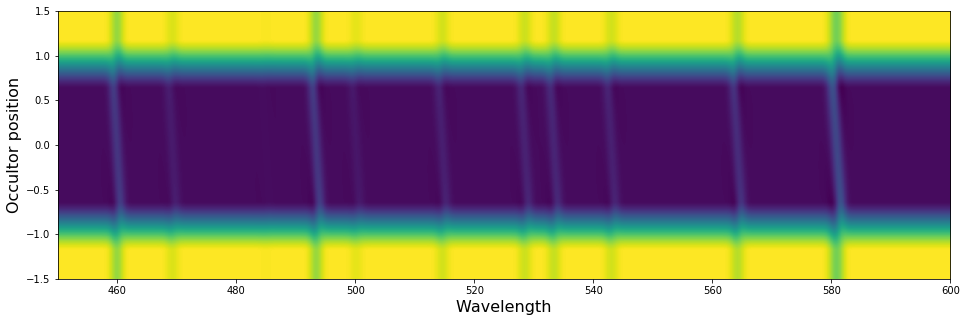

In [19]:
fig = plt.figure(figsize=(16,12))
fmean_quad = np.mean(flux_quad, axis=0).reshape(1, -1)
plt.imshow(flux_quad - fmean_quad, extent=(wav[0], wav[-1], xo[0], xo[-1]))
plt.gca().set_aspect(15)
plt.ylabel("Occultor position", fontsize=16)
plt.xlabel("Wavelength", fontsize=16);

And here's the base spectrum and the *difference* between the base spectrum when the planet is on the blue hemisphere and when it is on the red hemisphere:

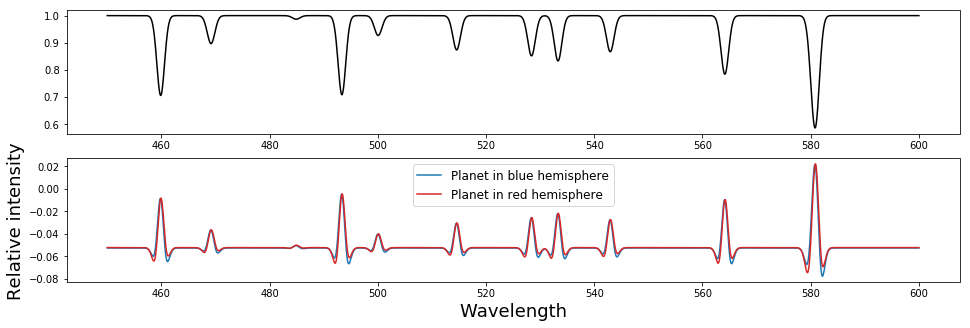

In [20]:
fig, ax = plt.subplots(2, figsize=(16, 5))
ax[0].plot(wav, I, "k")
ax[1].plot(wav, flux_quad[250, :] / np.pi - I, label="Planet in blue hemisphere", color="C0")
ax[1].plot(wav, flux_quad[750, :] / np.pi - I, label="Planet in red hemisphere", color="C3");
plt.xlabel("Wavelength", fontsize=18)
plt.ylabel("Relative intensity", fontsize=18);
plt.legend(fontsize=12);

Zoom in on a line:

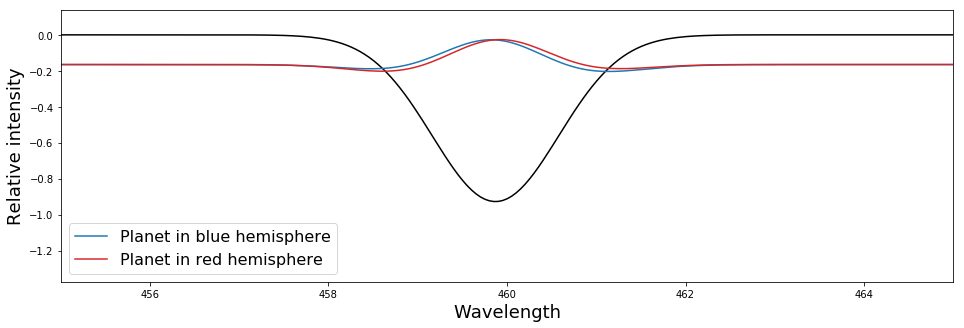

In [21]:
plt.figure(figsize=(16, 5))
plt.plot(wav, np.pi * (I - 1),  "k")
plt.plot(wav, flux_quad[250, :] - np.pi * I, label="Planet in blue hemisphere", color="C0")
plt.plot(wav, flux_quad[750, :] - np.pi * I, label="Planet in red hemisphere", color="C3");
plt.xlabel("Wavelength", fontsize=18)
plt.ylabel("Relative intensity", fontsize=18);
plt.legend(fontsize=16);
plt.xlim(455, 465);

### Let's compute the disk-integrated spectrum

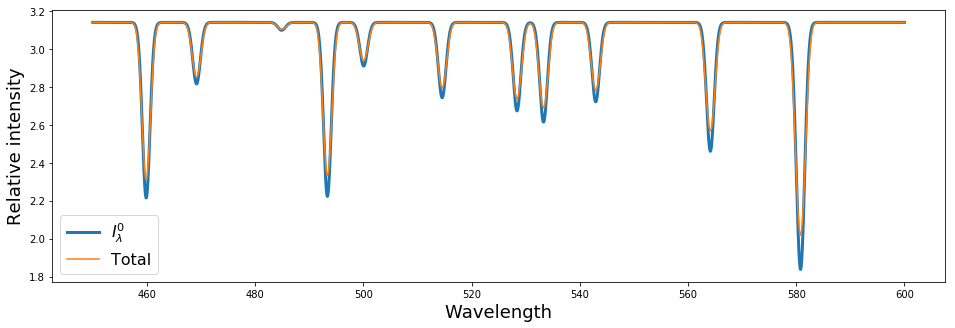

In [22]:
plt.figure(figsize=(16, 5))
plt.plot(wav, np.pi * I, label=r"$I_\lambda^0$", lw=3)
plt.plot(wav, map_quad.flux().reshape(-1, 1), label="Total")
plt.xlabel("Wavelength", fontsize=18)
plt.ylabel("Relative intensity", fontsize=18);
plt.legend(fontsize=16);

Zoom in on a line: it's slightly broadened!

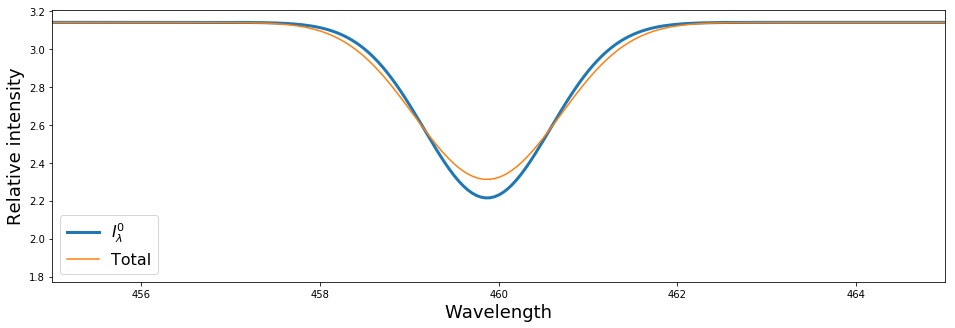

In [23]:
plt.figure(figsize=(16, 5))
plt.plot(wav, np.pi * I, label=r"$I_\lambda^0$", lw=3)
plt.plot(wav, map_quad.flux().reshape(-1, 1), label="Total")
plt.xlabel("Wavelength", fontsize=18)
plt.ylabel("Relative intensity", fontsize=18);
plt.legend(fontsize=16);
plt.xlim(455, 465);

## A more realistic system

Let's give the star a more realistic velocity and make the planet smaller so we can compute the RM "waveform".

In [24]:
c = 3.00e8
veq = 5 * 1e3
beta = veq / c

In [25]:
xo = np.linspace(-1.5, 1.5, 1000)
yo = -0.4
ro = 0.1

### Compute our two model spectra

In [26]:
# Linear model
map_lin = starry.Map(3, nwav=nwav)
map_lin[0, 0] = np.pi * I
map_lin[1, 1] = (np.pi / np.sqrt(3)) * beta * dIdb[0]
flux_lin = map_lin.flux(xo=xo, yo=yo, ro=ro)

# Quadratic model
map_quad = starry.Map(3, nwav=nwav)
map_quad[0, 0] = np.pi * I
map_quad[1, 1] = (np.pi / np.sqrt(3)) * beta * dIdb[0]
map_quad[0, 0] += (np.pi / 3) * beta ** 2 * dIdb[1]
map_quad[2, 0] -= (np.sqrt(5) * np.pi / 15) * beta ** 2 * dIdb[1]
map_quad[2, 2] += (np.sqrt(5) * np.pi / 15) * beta ** 2 * dIdb[1]
flux_quad = map_lin.flux(xo=xo, yo=yo, ro=ro)

### Let's compute the RM "waveform"

Let's cross-correlate the spectrum with the spectrum at time $t = 0$.

In [27]:
crosscor_lin = np.array([np.correlate(flux_lin[i], flux_lin[0], mode="full") for i in range(len(flux_lin))])

In [28]:
crosscor_quad = np.array([np.correlate(flux_quad[i], flux_quad[0], mode="full") for i in range(len(flux_quad))])

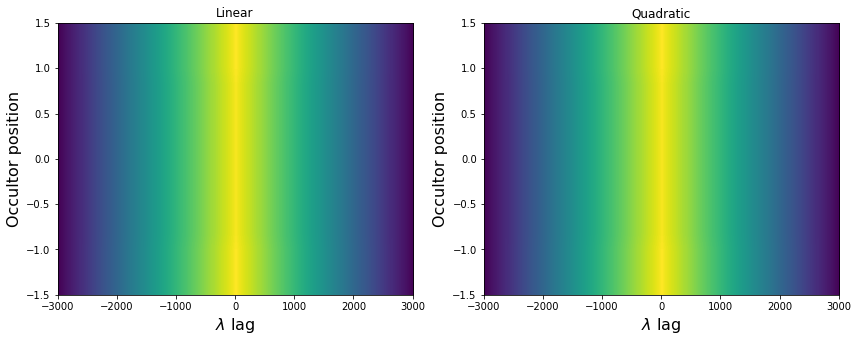

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].imshow(crosscor_lin, extent=(-nwav, nwav, xo[0], xo[-1]), origin="lower")
ax[0].set_aspect('auto')
ax[0].set_title("Linear")
ax[0].set_xlabel(r"$\lambda$ lag", fontsize=16)
ax[0].set_ylabel("Occultor position", fontsize=16);
ax[1].imshow(crosscor_quad, extent=(-nwav, nwav, xo[0], xo[-1]), origin="lower")
ax[1].set_aspect('auto')
ax[1].set_title("Quadratic")
ax[1].set_xlabel(r"$\lambda$ lag", fontsize=16)
ax[1].set_ylabel("Occultor position", fontsize=16);

In [30]:
# Let's use the method of Teague & Foreman-Mackey (2018)
# to find the maximum of the cross-correlation function
# as a function of occultor position:
dlam_lin = np.zeros_like(xo)
dlam_quad = np.zeros_like(xo)
for i in range(len(xo)):
    # Linear
    power = crosscor_lin[i]
    imax = np.argmax(power)
    I0 = power[imax]
    Ip = power[imax + 1]
    Im = power[imax - 1]
    a0 = I0
    a1 = 0.5 * (Ip - Im)
    a2 = 0.5 * (Ip + Im - 2 * I0)
    dlam_lin[i] = -0.5 * a1 / a2
    # Quadratic
    power = crosscor_quad[i]
    imax = np.argmax(power)
    I0 = power[imax]
    Ip = power[imax + 1]
    Im = power[imax - 1]
    a0 = I0
    a1 = 0.5 * (Ip - Im)
    a2 = 0.5 * (Ip + Im - 2 * I0)
    dlam_quad[i] = -0.5 * a1 / a2

In [31]:
# Let's convert delta lambda to a velocity,
# taking lambda_0 to be the midpoint of the
# spectrum. We'll compute `v` in m/s
v_lin = (dlam_lin / wav[len(wav) // 2]) * c
v_quad = (dlam_quad / wav[len(wav) // 2]) * c

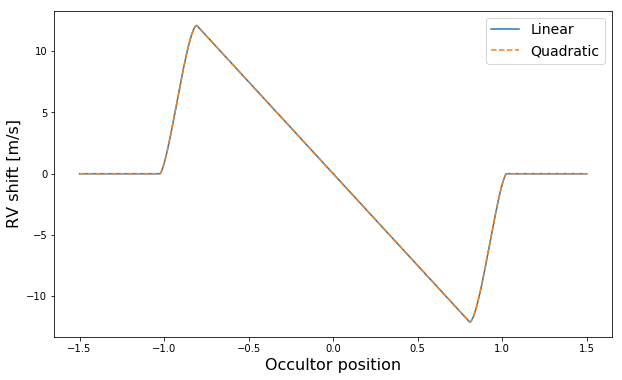

In [32]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(xo, v_lin, label="Linear")
ax.plot(xo, v_quad, '--', label="Quadratic")
ax.set_xlabel("Occultor position", fontsize=16)
ax.set_ylabel("RV shift [m/s]", fontsize=16);
ax.legend(fontsize=14);

**Boom!**